In [1]:
!mkdir results
!ls

results  sample_data


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args

# Data Preparation

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Model Architecture

In [51]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [71]:
class CNN(nn.Module):
    def __init__(self, model_code, in_channels, out_dim, act, use_bn):
        super(CNN, self).__init__()

        if act == 'relu':
            self.act = nn.ReLU()
        elif act == 'sigmoid':
            self.act = nn.Sigmoid()
        elif act == 'tanh':
            self.act = nn.Tanh()
        else:
            raise ValueError("Not a valid activation function code")

        self.layers = self._make_layers(model_code, in_channels, use_bn)
        self.classifier = nn.Sequential(nn.Linear(512, 256),
                                        self.act,
                                        nn.Linear(256, out_dim))
        
    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def _make_layers(self, model_code, in_channels, use_bn):
        layers = []
        for x in cfg[model_code]:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels=in_channels,
                                     out_channels=x,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)]
                if use_bn:
                    layers += [nn.BatchNorm2d(x)]
                layers += [self.act]
                in_channels = x           
        return nn.Sequential(*layers)

In [53]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=64,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=64,
                               out_channels=256,
                               kernel_size=5,
                               stride=1,
                               padding=2)
        self.act = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,
                                     stride=2)
        self.fc = nn.Linear(65536, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.maxpool1(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [69]:
def dimension_check():
    net = CNN('VGG11', 3)
    x = torch.randn(2, 3, 32, 32)
    y = net(x)
    print(y.size())

In [70]:
dimension_check()

torch.Size([2, 10])


# Train, Validate, Test and Experiment

In [45]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [46]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [47]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [72]:
def experiment(partition, args):
  
    # net = CNN2()
    net = CNN(model_code = args.model_code,
              in_channels = args.in_channels,
              out_dim = args.out_dim,
              act = args.act,
              use_bn = args.use_bn)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result
    # ===================================== #

# Manage Experiment Result

In [77]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [ ]:
load_exp_result('exp1')

""


# Experiment

In [78]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr_model_code"

# ====== Model Capacity ====== #
args.model_code = 'VGG11'
args.in_channels = 3
args.out_dim = 10
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.00001
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'model_code'
list_var1 = [0.001, 0.0001]
list_var2 = ['VGG11', 'VGG13']


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', epoch=10, exp_name='exp1_lr_model_code', in_channels=3, l2=1e-05, lr=0.001, model_code='VGG11', optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=512, use_bn=True)
Epoch 0, Acc(train/val): 18.56/10.50, Loss(train/val) 2.14/2.46. Took 26.25 sec
Epoch 1, Acc(train/val): 28.84/25.14, Loss(train/val) 1.79/2.25. Took 26.03 sec
Epoch 2, Acc(train/val): 41.88/26.70, Loss(train/val) 1.50/2.21. Took 25.83 sec
Epoch 3, Acc(train/val): 52.28/32.19, Loss(train/val) 1.27/2.26. Took 25.89 sec
Epoch 4, Acc(train/val): 59.85/38.66, Loss(train/val) 1.10/2.12. Took 25.79 sec
Epoch 5, Acc(train/val): 66.39/32.24, Loss(train/val) 0.93/2.85. Took 26.04 sec
Epoch 6, Acc(train/val): 71.06/51.16, Loss(train/val) 0.81/1.69. Took 26.07 sec
Epoch 7, Acc(train/val): 75.58/57.44, Loss(train/val) 0.70/1.44. Took 26.06 sec
Epoch 8, Acc(train/val): 78.45/50.64, Loss(train/val) 0.62/1.63. Took 26.07 sec
Epoch 9, Acc(train/val): 81.31/56.73, Loss(train/val) 0.54/1.87. Took 25.95 

In [79]:
!ls results 
!cat results/exp1_n_layer_hid_dim-41b634.json

exp1_lr_model_code-6807ec.json	exp1_lr_model_code-9bf3b7.json
exp1_lr_model_code-917c80.json	exp1_lr_model_code-d68fff.json
cat: results/exp1_n_layer_hid_dim-41b634.json: No such file or directory


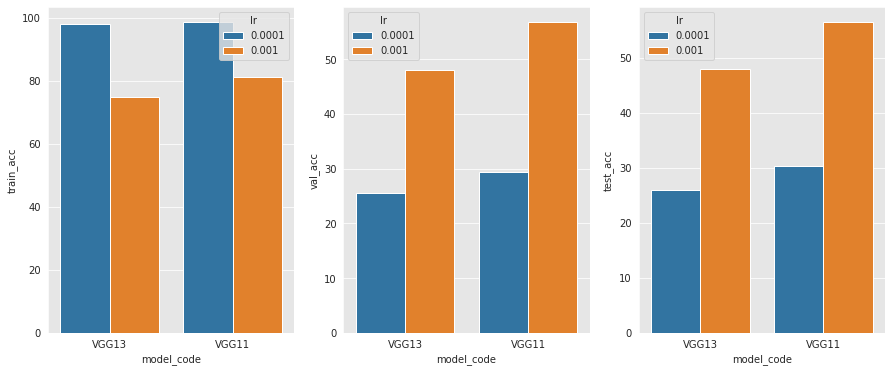

In [82]:
import seaborn as sns 
import matplotlib.pyplot as plt

df = load_exp_result('exp1')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.barplot(x='model_code', y='train_acc', hue='lr', data=df, ax=ax[0])
sns.barplot(x='model_code', y='val_acc', hue='lr', data=df, ax=ax[1])
sns.barplot(x='model_code', y='test_acc', hue='lr', data=df, ax=ax[2])

['VGG13' 'VGG11'] [0.0001 0.001 ]


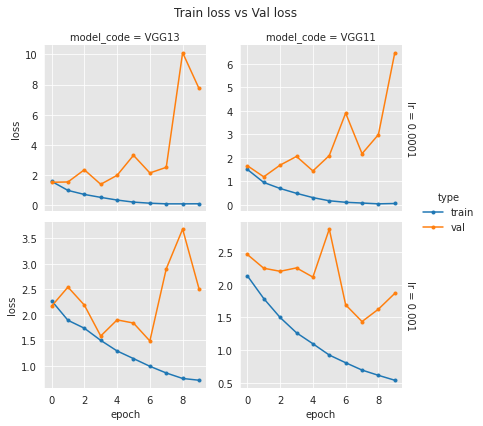

In [83]:
var1 = 'model_code'
var2 = 'lr'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
print(list_v1, list_v2)
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]

        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

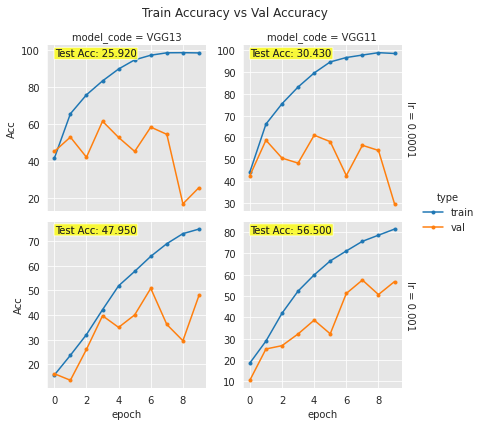

In [85]:
var1 = 'model_code'
var2 = 'lr'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')
plt.subplots_adjust(top=0.89)